# TLC Trip Record Data

- 출처: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("24121003_yellowtaxi_trip_count").getOrCreate()

24/12/12 09:33:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
import os
trip_files= '/trip/*'
zone_file= 'taxi+_zone_lookup.csv'
directory = os.path.join(os.getcwd(), 'data')

In [3]:
trips_df = spark.read.csv(f'file:///{directory}/{trip_files}', inferSchema=True, header=True)

In [4]:
zone_df= spark.read.csv(f'file:///{directory}/{zone_file}', inferSchema=True, header=True)

In [5]:
trips_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [9]:
trips_df.createOrReplaceTempView('trip')
zone_df.createOrReplaceTempView('zone')

In [10]:
query= '''
select
t.VendorID,
TO_DATE(t.tpep_pickup_datetime) as pickup_date,
TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
HOUR(t.tpep_pickup_datetime)  as pickup_time,
HOUR(t.tpep_dropoff_datetime) as dropoff_time,
t.passenger_count,
t.trip_distance,
t.tip_amount,
t.payment_type,
pz.Zone as pickup_zone,
dz.Zone as dropoff_zone

from trip t
LEFT JOIN zone pz ON t.PULocationID = pz.LocationID
LEFT JOIN zone dz ON t.DOLocationID = dz.LocationID

'''

In [11]:
comb_df=spark.sql(query)

In [12]:
comb_df.show(5)

+--------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+-----------------+--------------+
|VendorID|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|tip_amount|payment_type|      pickup_zone|  dropoff_zone|
+--------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+-----------------+--------------+
|       2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|       0.0|           2|               NV|            NV|
|       2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|       0.0|           2|   Manhattanville|Manhattanville|
|       2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|       0.0|           2|   Manhattanville|Manhattanville|
|       1| 2021-03-01|  2021-03-01|          0|           0|              0|         16.5|     11.65|           

In [13]:
comb_df.createOrReplaceTempView('comb')

In [14]:
query= '''
select pickup_date, pickup_time
from comb
where pickup_time>0
'''

In [15]:
spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-03-01|         22|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [16]:
query = '''
select pickup_date, pickup_time
from comb
where pickup_date<'2020-12-31'
'''
spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [17]:
comb_df.describe()

DataFrame[summary: string, VendorID: string, pickup_time: string, dropoff_time: string, passenger_count: string, trip_distance: string, tip_amount: string, payment_type: string, pickup_zone: string, dropoff_zone: string]

In [ ]:
#select pickup_date, pickup_time 
# from comb 
# where pickup_date<'2020-12-31'
spark.sql(query).explain()

In [18]:
#실행계획 

In [19]:
spark.sql(query).explain()

== Physical Plan ==
*(3) Project [cast(tpep_pickup_datetime#17 as date) AS pickup_date#76, hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) AS pickup_time#78]
+- *(3) BroadcastHashJoin [DOLocationID#24], [LocationID#82], LeftOuter, BuildRight, false
   :- *(3) Project [tpep_pickup_datetime#17, DOLocationID#24]
   :  +- *(3) BroadcastHashJoin [PULocationID#23], [LocationID#68], LeftOuter, BuildRight, false
   :     :- *(3) Filter (isnotnull(tpep_pickup_datetime#17) AND (cast(tpep_pickup_datetime#17 as date) < 18627))
   :     :  +- FileScan csv [tpep_pickup_datetime#17,PULocationID#23,DOLocationID#24] Batched: false, DataFilters: [isnotnull(tpep_pickup_datetime#17), (cast(tpep_pickup_datetime#17 as date) < 18627)], Format: CSV, Location: InMemoryFileIndex[file:/home/lab10/git_project/src/data/trip/yellow_tripdata_2021-01.csv, file:/h..., PartitionFilters: [], PushedFilters: [IsNotNull(tpep_pickup_datetime)], ReadSchema: struct<tpep_pickup_datetime:string,PULocationID:i

In [20]:
#실행계획, 실행결과 (4040)

In [21]:
query2 = '''
select pickup_date, pickup_time
from comb
where pickup_time>0 and pickup_time <=12 
'''
spark.sql(query2).show()   

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [22]:
spark.sql(query2).explain()

== Physical Plan ==
*(3) Project [cast(tpep_pickup_datetime#17 as date) AS pickup_date#76, hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) AS pickup_time#78]
+- *(3) BroadcastHashJoin [DOLocationID#24], [LocationID#82], LeftOuter, BuildRight, false
   :- *(3) Project [tpep_pickup_datetime#17, DOLocationID#24]
   :  +- *(3) BroadcastHashJoin [PULocationID#23], [LocationID#68], LeftOuter, BuildRight, false
   :     :- *(3) Filter ((isnotnull(tpep_pickup_datetime#17) AND (hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) > 0)) AND (hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) <= 12))
   :     :  +- FileScan csv [tpep_pickup_datetime#17,PULocationID#23,DOLocationID#24] Batched: false, DataFilters: [isnotnull(tpep_pickup_datetime#17), (hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/..., Format: CSV, Location: InMemoryFileIndex[file:/home/lab10/git_project/src/data/trip/yellow_tripdata_2021-01.csv, file:/h..., PartitionFil

In [23]:
query3 = '''
select pickup_date , count(*) as trip_count
from comb 
where pickup_time > 0
group by pickup_date
order by pickup_date
'''

In [24]:
spark.sql(query3).show()   

+-----------+----------+
|pickup_date|trip_count|
+-----------+----------+
| 2002-12-31|         1|
| 2003-01-05|         1|
| 2004-04-04|         1|
| 2008-12-31|        26|
| 2009-01-01|        46|
| 2020-12-31|        16|
| 2021-01-01|     23649|
| 2021-01-02|     34045|
| 2021-01-03|     25881|
| 2021-01-04|     44210|
| 2021-01-05|     46539|
| 2021-01-06|     49210|
| 2021-01-07|     50013|
| 2021-01-08|     50122|
| 2021-01-09|     39407|
| 2021-01-10|     29275|
| 2021-01-11|     46568|
| 2021-01-12|     49878|
| 2021-01-13|     51045|
| 2021-01-14|     52763|
+-----------+----------+
only showing top 20 rows



In [48]:
spark.sql(query3).explain()   

== Physical Plan ==
*(5) Sort [pickup_date#94 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(pickup_date#94 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#821]
   +- *(4) HashAggregate(keys=[pickup_date#94], functions=[count(1)])
      +- Exchange hashpartitioning(pickup_date#94, 200), ENSURE_REQUIREMENTS, [id=#817]
         +- *(3) HashAggregate(keys=[pickup_date#94], functions=[partial_count(1)])
            +- *(3) Project [cast(tpep_pickup_datetime#17 as date) AS pickup_date#94]
               +- *(3) BroadcastHashJoin [DOLocationID#24], [LocationID#100], LeftOuter, BuildRight, false
                  :- *(3) Project [tpep_pickup_datetime#17, DOLocationID#24]
                  :  +- *(3) BroadcastHashJoin [PULocationID#23], [LocationID#68], LeftOuter, BuildRight, false
                  :     :- *(3) Filter (isnotnull(tpep_pickup_datetime#17) AND (hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) > 0))
                  :     :  +- FileScan csv [tpep_pic

In [ ]:
# 위와 비교 

In [ ]:
# 퀴리 분석 

In [29]:
#1. 운행 거리와 요금의 상관관계 분석  > 쿼리, 데이터프레임으로 구현


query='''
SELECT corr(trip_distance, fare_amount) AS correlation
FROM trip
'''

spark.sql(query).show()

+--------------------+
|         correlation|
+--------------------+
|0.001048464398956...|
+--------------------+



In [30]:
#DataFrame
correlation= trips_df.stat.corr("trip_distance", "fare_amount")
print(f" Correlation between trip_distance and fare_amount: {correlation}")

 Correlation between trip_distance and fare_amount: 0.0010484643989563014


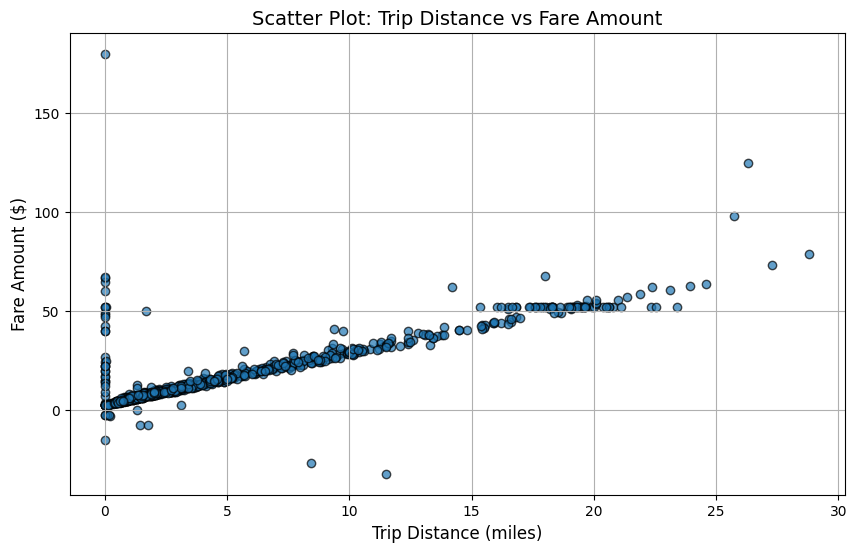

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = trips_df.select("trip_distance", "fare_amount").limit(1000).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["trip_distance"], pandas_df["fare_amount"], alpha=0.7, edgecolors='k')
plt.title("Scatter Plot: Trip Distance vs Fare Amount", fontsize=14)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.grid(True)
plt.show()


In [33]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 168.6 MB/s eta 0:00:00


In [34]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [24]:
# 2. 피크 시간대 요금 분석

query='''
SELECT HOUR(tpep_pickup_datetime)AS pickup_hour,
       COUNT(*)AS trip_count
FROM trip
GROUP BY HOUR(tpep_pickup_datetime)
ORDER BY trip_count DESC;

'''

In [25]:
spark.sql(query).show()

+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|         15|   1091871|
|         18|   1087217|
|         17|   1085226|
|         14|   1084111|
|         16|   1043498|
|         13|   1001522|
|         12|    970018|
|         19|    915477|
|         11|    877952|
|         10|    794621|
|          9|    712912|
|         20|    703748|
|          8|    641530|
|         21|    618735|
|         22|    548863|
|          7|    438938|
|         23|    426957|
|          0|    273553|
|          6|    241020|
|          1|    160424|
+-----------+----------+
only showing top 20 rows



In [26]:
# 3. 지불 유형별 요금, 팁 분석
query='''
SELECT
    payment_type,
    COUNT(*)AS trip_count,
    SUM(fare_amount)AS total_fare,
    AVG(fare_amount)AS avg_fare,
    SUM(tip_amount)AS total_tip,
    AVG(tip_amount)AS avg_tip
FROM trip
GROUP BY payment_type
ORDER BY total_tip DESC;
'''
spark.sql(query).show()

+------------+----------+--------------------+-------------------+-------------------+--------------------+
|payment_type|trip_count|          total_fare|           avg_fare|          total_tip|             avg_tip|
+------------+----------+--------------------+-------------------+-------------------+--------------------+
|           1|  10716903|1.3096067498999453E8|   12.2200112280567|3.086741502000679E7|  2.8802551464734534|
|        null|    834028|2.1754020310008034E7|  26.08308151525852| 1335652.4599999941|  1.6014479849597305|
|           2|   3308670| 3.947409457999995E7| 11.930502159477964| 1138.6399999999999|3.441382791272625...|
|           4|     59664| -124146.77999999997|-2.0807652855993557|  352.5900000000001|0.005909593724859213|
|           5|         1|                17.8|               17.8|                0.0|                 0.0|
|           3|     81434|  1334764.2100000002| 16.390748458874675|-1092.5699999999997|-0.01341663187366456|
+------------+----------+---

In [27]:
# 4. 승차지역/하차지역별 평균거리, 요금
query='''
SELECT PULocationID, DOLocationID, AVG(trip_distance)AS avg_trip_distance, AVG(fare_amount) AS avg_fare_amount
FROM trip
GROUP BY PULocationID,DOLocationID
ORDER BY avg_trip_distance DESC
'''


In [28]:
spark.sql(query).show()

+------------+------------+------------------+------------------+
|PULocationID|DOLocationID| avg_trip_distance|   avg_fare_amount|
+------------+------------+------------------+------------------+
|         131|         185|         205266.12|             37.53|
|         128|         205|         167305.08|              65.9|
|         175|          89|         131123.07|             57.63|
|          26|          56|          126653.9|             44.91|
|         147|         127|          77093.46|             18.24|
|          80|         200|         70968.425|44.495000000000005|
|         127|         182| 65796.09250000001|           28.5225|
|         215|          46|          56564.13|             41.41|
|         136|         193|          54215.12|             27.82|
|         131|          69|52683.263333333336|             40.36|
|          51|          49|49552.270000000004|              61.3|
|          29|          37|         45886.492|              48.1|
|         

In [31]:
# 5. 팁의 비율에 따른 거리, 여행 건수 서비스 관련 분석
query='''
SELECT CASE 
            WHEN (tip_amount /fare_amount) >= 0.2 THEN 'High Tip'
            WHEN (tip_amount/fare_amount) BETWEEN 0.1 AND 0.2 THEN 'Medium Tip'
            ELSE 'Low Tip'
        END AS tip_group,
        AVG(trip_distance) AS avg_trip_distance,
        COUNT(*) AS trip_count
FROM trip
WHERE fare_amount >0
      AND tip_amount >=0
GROUP BY tip_group
ORDER BY trip_count DESC;
'''

In [32]:
spark.sql(query).show()

+----------+------------------+----------+
| tip_group| avg_trip_distance|trip_count|
+----------+------------------+----------+
|  High Tip|3.6034455263086373|   8575938|
|   Low Tip|12.426316686087926|   4713052|
|Medium Tip| 5.785072667773372|   1636076|
+----------+------------------+----------+

